In [1]:
import torch
import triton
import triton.language as tl
from copy import deepcopy

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def rotate_half_inv(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, -x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

@triton.jit
def _fused_apply_rope_fwd(X, X_R, X_EMBED, COS, SIN,
                        stride_xb, stride_xl, stride_xh, stride_xd,
                        stride_cb, stride_cl, stride_cd,
                        H, D:tl.constexpr, BLOCK_H:  tl.constexpr,
                        ):
    pid = tl.program_id(0)
    x_offset = pid * stride_xl
    cos_offset = pid * stride_cl

    X += x_offset
    X_R += x_offset
    X_EMBED += x_offset
    COS += cos_offset
    SIN += cos_offset
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    x_ptrs = tl.make_block_ptr(
        base=X,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xr_ptrs = tl.make_block_ptr(
        base=X_R,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xembed_ptrs = tl.make_block_ptr(
        base=X_EMBED,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)
    x = tl.load(x_ptrs, boundary_check=(0,), padding_option='zero')
    xr = tl.load(xr_ptrs, boundary_check=(0,), padding_option='zero')
    x_embed = x * cos[None, :] + xr * sin[None, :]
    tl.store(xembed_ptrs, x_embed, boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        # 要求1: qk输入是[bs, num_head, seq_len, head_dim]，并且是内存不连续的
        # 要求2: head_dim 必须是2的指数倍, 一般都是64或者128     
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        assert q.is_contiguous() and k.is_contiguous()
        qh = q.size(2)
        kh = k.size(2)
        x = torch.cat([q,k],axis=2)
        x_rotate_half = rotate_half(x)
        B, L, H, D = x.shape
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        
        BLOCK_H = triton.next_power_of_2(H)
        x_embed = torch.empty_like(x)
        num_warps=8
        num_stages=1 
        M = B*L
        _fused_apply_rope_fwd[(M,)](x, x_rotate_half, x_embed, cos, sin,
                        *x.stride(),
                        *cos.stride(),
                        H,D, BLOCK_H,
                        num_warps=num_warps, num_stages=num_stages

        )
        q_embed, k_embed = x_embed.split([qh, kh], dim=2)
        ctx.save_for_backward(cos, sin)
        return q_embed.transpose(1,2), k_embed.transpose(1,2)
    
    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        cos,sin = ctx.saved_tensors
        c = (cos + rotate_half_inv(sin)).unsqueeze(1)
        return dq_embed*c, dk_embed*c, None, None




fused_apply_rope = _FusedApplyRope.apply



# 精度测试

In [4]:
device = 'cuda'
dtype = torch.float16
bs, seq_len, num_head, head_dim = 4, 256, 40, 128
q1 = torch.randn(bs, seq_len, num_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q1.requires_grad_(True)
k1  = torch.randn(bs, seq_len, num_head, head_dim,device=device, dtype=dtype).transpose(1,2)
k1.requires_grad_(True)
q2 = torch.randn(bs, seq_len, num_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q2.data.copy_(q1.data)
q2.requires_grad_(True)
k2  = torch.randn(bs, seq_len, num_head, head_dim, device=device, dtype=dtype).transpose(1,2)
k2.data.copy_(k1.data)
k2.requires_grad_(True)
cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
sin = torch.randn_like(cos)


In [5]:
if k1.grad is not None:
    k1.grad.zero_()
    q1.grad.zero_()
q_embed1, k_embed1 = apply_rotary_pos_emb(q1, k1, cos, sin)
(q_embed1 + k_embed1).sum().backward()

if k2.grad is not None:
    k2.grad.zero_()
    q2.grad.zero_()
q_embed2, k_embed2 = apply_rotary_pos_emb(q2, k2, cos, sin)
(q_embed2 + k_embed2).sum().backward()

print(torch.allclose(q_embed1, q_embed2), torch.allclose(k_embed1, k_embed2))
print(torch.allclose(q1.grad, q2.grad), torch.allclose(k1.grad, k2.grad))

True True
True True


# forward

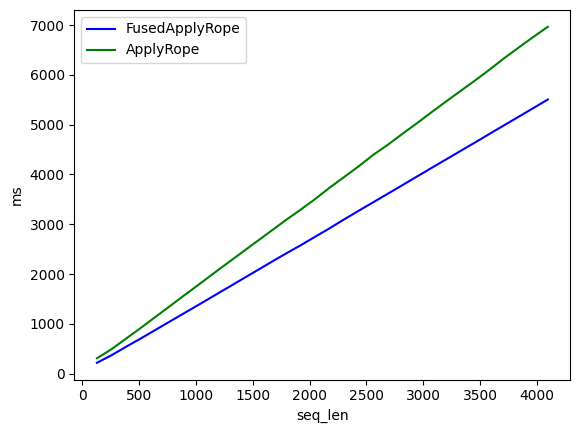

forward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      216.296673   306.667536
1     256.0      367.547512   489.419311
2     384.0      537.814915   701.670349
3     512.0      702.505171   914.172232
4     640.0      873.211145  1133.027315
5     768.0     1043.700933  1351.219654
6     896.0     1213.970661  1571.700931
7    1024.0     1383.485198  1788.302183
8    1152.0     1555.635452  2007.417202
9    1280.0     1727.024317  2224.619389
10   1408.0     1899.034739  2439.789534
11   1536.0     2070.315599  2656.038284
12   1664.0     2242.921114  2870.590210
13   1792.0     2412.681103  3086.721182
14   1920.0     2576.848030  3292.981863
15   2048.0     2748.822927  3506.424904
16   2176.0     2919.508934  3736.262560
17   2304.0     3098.910809  3949.816942
18   2432.0     3271.611691  4165.303707
19   2560.0     3442.845583  4395.803452
20   2688.0     3613.597631  4597.198963
21   2816.0     3785.393715  4816.573143
22   2944.0     3958.665609  5029.810429
23   30

In [10]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':8, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fused_apply_rope(q, k, cos, sin))
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: apply_rotary_pos_emb(q, k, cos, sin))

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# backward

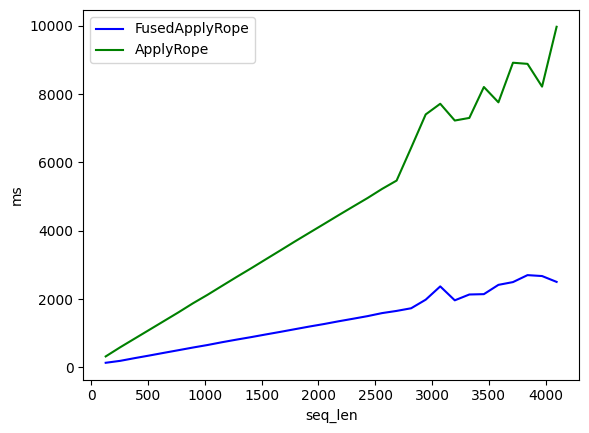

backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      137.828320   323.900878
1     256.0      194.730759   592.451990
2     384.0      274.574220   847.529531
3     512.0      350.226730  1102.472067
4     640.0      428.793937  1357.938886
5     768.0      506.021500  1613.392711
6     896.0      584.251821  1879.224420
7    1024.0      657.731414  2127.138376
8    1152.0      739.718616  2389.024973
9    1280.0      816.038489  2649.215221
10   1408.0      889.002681  2903.427124
11   1536.0      966.522336  3164.424181
12   1664.0     1041.888475  3424.082279
13   1792.0     1120.313287  3686.507463
14   1920.0     1198.188543  3942.346334
15   2048.0     1271.244764  4197.528839
16   2176.0     1351.172328  4454.602242
17   2304.0     1426.133752  4707.603931
18   2432.0     1502.953410  4958.490372
19   2560.0     1591.821432  5226.217270
20   2688.0     1655.796885  5470.179558
21   2816.0     1733.526349  6430.360794
22   2944.0     1984.333277  7406.144619
23   3

In [11]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':64, 'kh':8, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'FusedApplyRope':
        a,b = fused_apply_rope(q, k, cos, sin)
        loss = a.sum() + b.sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        a,b = apply_rotary_pos_emb(q, k, cos, sin)
        loss = a.sum() + b.sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

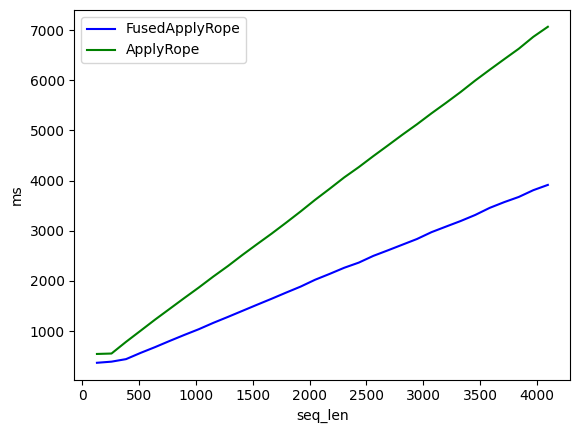

forward + backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      369.043559   544.964254
1     256.0      391.456455   553.528786
2     384.0      441.867143   786.447763
3     512.0      566.053152  1007.847309
4     640.0      681.829512  1230.558157
5     768.0      804.400086  1444.193125
6     896.0      923.313260  1658.465743
7    1024.0     1038.013935  1868.629813
8    1152.0     1164.814353  2087.793350
9    1280.0     1282.848477  2296.476841
10   1408.0     1403.866529  2518.539667
11   1536.0     1525.124431  2731.883287
12   1664.0     1644.351363  2941.714525
13   1792.0     1767.440319  3160.652399
14   1920.0     1887.283921  3384.845018
15   2048.0     2024.469852  3617.692471
16   2176.0     2141.036987  3837.897301
17   2304.0     2263.061762  4064.207554
18   2432.0     2365.576506  4268.951416
19   2560.0     2499.771595  4488.358498
20   2688.0     2610.076427  4700.710297
21   2816.0     2723.189116  4915.619850
22   2944.0     2836.124182  5122.836

In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':28, 'kh':4, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def fwd_bwd(func, *args):
        a,b = func(*args)
        loss = a.sum() + b.sum()
        loss.backward(retain_graph=True)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(fused_apply_rope, q, k, cos, sin), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(apply_rotary_pos_emb, q, k, cos, sin), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
